In [1]:
# To install latest version of cupy 

!curl https://colab.chainer.org/install | CHAINER_VERSION="==6.5.0" CUPY_VERSION="==6.5.0" sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  27241      0 --:--:-- --:--:-- --:--:-- 27241
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
+ pip install -q cupy-cuda100 ==6.5.0 chainer ==6.5.0
+ set +ex
Installation succeeded!


In [0]:
import cupy as cp
import numpy as np
import time
import matplotlib.pyplot as plt
from __future__ import print_function

In [0]:
#GAP_SCORE = -3
#MATCH_SCORE_TWO_SEQ = 100
#PENALTY_3_ALIGNMENTS = 120


GAP_SCORE = -40
EGAP_SCORE = -2
MATCH_SCORE_TWO_SEQ = 83
PENALTY_3_ALIGNMENTS = 0

# With PENALTY_3_ALIGNMENTS = 120



In [0]:
import numpy as np
from sympy import binomial
import os
from __future__ import print_function

In [0]:
def arrayPositionInMatrix(len_sequence, number_cells_computed):
    """
    
    Creates a 1D arrays which indicate for each time step the position 
    of the cells to compute in a Needleman and Wunch flattened matrix. 
    Works only for the alignment of 3 sequences with the same size.
    
    Parameters
    ----------
    len_sequence: int
        The size of the sequences which are aligned.
      
    number_cells_computed: 1D array
        Array which indicate the cumulative total number of cells computed 
        at each time step.
    
    Returns
    -------
    position_in_nw_flatten_matrix: 1D array
        Array which indicate the position of the cells to compute in a Needleman
        and Wunch flattened matrix.
    """
    
    number_steps = 3 * len_sequence - 2  # We can know the number of time steps to entirely compute the NW matrix with the theorie
    shape_matrix = ((len_sequence + 1, len_sequence + 1, len_sequence + 1)) # The "+ 1" to not be bothered with the boundaries

    position_x = [0] # position x of the elements which are computed in a 3D matrix
    position_y = [0] # position y of the elements which are computed in a 3D matrix
    position_z = [0] # position z of the elements which are computed in a 3D matrix

    position_in_nw_flatten_matrix = np.empty(shape=((len_sequence)**3, ), dtype=np.int32)
    # Needleman and Wunch matrix flattened 

    for time in range(1, number_steps + 1):
        print("\r{} / {}".format(time, number_steps), end='')
        position_cells_to_compute = np.vstack((position_x, position_y, position_z))


         
        interval1 = number_cells_computed[time-1]
        interval2 = number_cells_computed[time]

        position_in_nw_flatten_matrix[interval1:interval2] = np.ravel_multi_index(position_cells_to_compute + 1, shape_matrix) # The "+ 1" to not be bothered with the boundaries


        ## We update the position of the cells to compute for the next time step
        if (time < len_sequence):
            compteur = 0
            for i in range(time+1):
                position_x.insert(compteur, time-i)
                compteur += i+1

            position_y += list(np.arange(time + 1))
            position_z += list(np.arange(time, -1, -1))
        elif (time < 2 * len_sequence):
            compteur = 0
            for i in range(len_sequence):
                if (i+1 < 2*len_sequence - time):
                    position_x.insert(compteur, len_sequence - i - 1)
                    if (compteur == 0):
                        compteur += time - len_sequence + 2
                    else:
                        compteur += time - len_sequence + 2+i
                else:
                    position_x.pop(compteur)
                    compteur += len_sequence + 2*len_sequence - time - 2 - i

            position_y = position_y[time-len_sequence+1:] + list(np.arange(time-len_sequence + 1, len_sequence))
            position_z = position_z[time-len_sequence+1:] + list(np.arange(len_sequence - 1, time-len_sequence, -1))

        else:
            compteur = 0
            for i in range(3*len_sequence - time - 1):
                position_x.pop(compteur)
                compteur += 3*len_sequence - time - 2 - i

            position_y = position_y[3*len_sequence - time -1 :]
            position_z = position_z[3*len_sequence - time - 1:]

    return position_in_nw_flatten_matrix

In [0]:
def CalculProcessingUnitRequired(dimension, time_step, len_sequence):
  
    """
    
    Calculate for a time step the number of cells which can be computed in
    parallele in a Needleman and Wunch matrix.
    
    
    Parameters
    ----------
    dimension: int
        The dimension of the Needleman and Wunch matrix (it correspond to the 
        number of sequences that needs to be aligned).
      
    time_step: int
        Time step 
        
    len_sequence: int
        The size of the sequences which are aligned.
    
    Returns
    -------
    number_cells: int
        Number of cells which can be computed in parallele.
  
  
    """
    
    number_cells = 0
    coefficient_to_add = time_step // len_sequence
    for q in range(coefficient_to_add + 1):
        coefficient = int((-1)**(q) * binomial(dimension + time_step - q*len_sequence - 2, time_step - q*len_sequence - 1) * binomial(dimension, q))
        number_cells += coefficient
    return number_cells


def getNumberProcessingUnitRequired(len_sequence, dimension): # Calcule le nombre de processing unit entre time = 0 et time = (NM - N-1) 
  
    """
    
    Create an array where each elements of index i indicate the number of cells 
    which can be computed in parallele in a Needleman and Wunch matrix at the 
    time step i.
    
    Parameters
    ----------
    len_sequence: int
        The size of the sequences which are aligned.
    
    dimension: int
        The dimension of the Needleman and Wunch matrix (it correspond to the 
        number of sequences that needs to be aligned).
        
    Returns
    -------
    nb_cells_by_time_step: 1D array
        Array where each element of index i indicate the number of cells that 
        you can compute in a Needleman and Wunch matrix at time step = i
    
    
    """
    
    number_time_step = (dimension * len_sequence) - (dimension-1) # See the theorie to understand the total number of time step 
    nb_cells_by_time_step = np.empty((number_time_step+1, ), np.int32)
    nb_cells_by_time_step[0] = 0 # at time step 0, we compute 0 cells
    for i in range(1, number_time_step + 1): 
        nb_cells_by_time_step[i] = CalculProcessingUnitRequired(dimension, i, len_sequence)
    return nb_cells_by_time_step

In [6]:
len_sequence = 600 # Enter the sequence you want here
len_sequence += 1 # The sequences which are aligned have a size len_sequence + 1 because we add a gap element at the beginning of the sequences
nb_cells_by_time_step = getNumberProcessingUnitRequired(len_sequence, 3)
cumul_cells = nb_cells_by_time_step.cumsum()
position_in_nw_flatten_matrix = arrayPositionInMatrix(len_sequence, cumul_cells)

1801 / 1801

In [10]:
print("\nSAVING THE POSITION OBTAINED")

name_directory = "lenSeq_" + str(len_sequence)
!mkdir $name_directory

np.save(name_directory + "/position_cells_to_compute", position_in_nw_flatten_matrix) # M^N SPACE
np.save(name_directory + "/number_cells_computed", cumul_cells) # M*N SPACE

print("END OF SAVING")


SAVING THE POSITION OBTAINED


NameError: ignored

In [0]:
def computeScoringMatrix(seq1, seq2, seq3):
    tempsPasseAtEachStep = []
    lenSequence = len(seq1)
    scoreMatrix = cp.zeros((lenSequence + 1, lenSequence + 1, lenSequence + 1), cp.int32) # THE +1 TO NOT HAVE PROBLEMS WITH THE BOUNDARIES


    scoreMatrix[0, :, :] = scoreMatrix[:, :, 0] = scoreMatrix[:, 0, :] = - 256*lenSequence
    scoreMatrix[1, 1, 1] = 0 # to help us


    scoreMatrix_flatten = scoreMatrix.ravel()

    shapeMatrix = scoreMatrix.shape
    findPathMatrix = cp.zeros((lenSequence, lenSequence, lenSequence))
    total_number_steps = 3 * lenSequence - 2


    # TEST
    index_max = cp.full((lenSequence + 1, lenSequence + 1, lenSequence + 1), -1, cp.int32)
    index_max_flatten = index_max.ravel()
    #G = scoreMatrix_flatten.copy()
    #H = scoreMatrix_flatten.copy()
    #I = scoreMatrix_flatten.copy()
    #K = scoreMatrix_flatten.copy()
    #L = scoreMatrix_flatten.copy()
    #M = scoreMatrix_flatten.copy()
    # END TEST

    path = []




    for step in range(2, total_number_steps + 1):
        begin = time.time()
        print("\r{} / {}".format(step, total_number_steps), end='')

        interval1 = indexPositionArray[step-1]
        interval2 = indexPositionArray[step]
        
        pos_cells_to_compute = position_in_nw_flatten_matrix[interval1:interval2]
        #We get the position of all the neighbooring cells
        
        Gap_score_depth = GAP_SCORE - ((index_max_flatten[pos_cells_to_compute - (lenSequence+1)**2] == 1) + (index_max_flatten[pos_cells_to_compute - (lenSequence+1)**2] == 2) + (index_max_flatten[pos_cells_to_compute - (lenSequence+1)**2] == 5))*(GAP_SCORE - EGAP_SCORE)
        Gap_score_line = GAP_SCORE - ((index_max_flatten[pos_cells_to_compute - (lenSequence+1)] == 0) + (index_max_flatten[pos_cells_to_compute - (lenSequence+1)] == 2) + (index_max_flatten[pos_cells_to_compute - (lenSequence+1)] == 4))*(GAP_SCORE - EGAP_SCORE)
        Gap_score_column = GAP_SCORE - ((index_max_flatten[pos_cells_to_compute - 1] == 0) + (index_max_flatten[pos_cells_to_compute - 1] == 1) + (index_max_flatten[pos_cells_to_compute - 1] == 3))*(GAP_SCORE - EGAP_SCORE)


        
        #scoreMatrix_depth_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)**2] + 2*GAP_SCORE
        #scoreMatrix_line_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)] + 2*GAP_SCORE
        #scoreMatrix_column_minus1 = scoreMatrix_flatten[pos_cells_to_compute - 1] + 2*GAP_SCORE


        scoreMatrix_depth_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)**2] + Gap_score_line + Gap_score_column
        scoreMatrix_line_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)] + Gap_score_depth + Gap_score_column
        scoreMatrix_column_minus1 = scoreMatrix_flatten[pos_cells_to_compute - 1] + Gap_score_depth + Gap_score_line


        ## Compute the state for the changements in 1 dimension:
        maxOneDimMinusOne = cp.maximum(scoreMatrix_depth_minus1, cp.maximum(scoreMatrix_line_minus1, scoreMatrix_column_minus1))
        """
        ########################### TEST
        G[pos_cells_to_compute] = cp.maximum(scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)**2 - 1] + 2*GAP_SCORE, G[pos_cells_to_compute - (lenSequence+1)**2 - 1] + 2*EGAP_SCORE)
        H[pos_cells_to_compute] = cp.maximum(scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)] + 2*GAP_SCORE, H[pos_cells_to_compute - (lenSequence+1)] + 2*EGAP_SCORE)
        I[pos_cells_to_compute] = cp.maximum(scoreMatrix_flatten[pos_cells_to_compute - 1] + 2*GAP_SCORE, I[pos_cells_to_compute - 1] + 2*EGAP_SCORE)

        maxOneDimMinusOne = cp.maximum(G[pos_cells_to_compute], cp.maximum(H[pos_cells_to_compute], I[pos_cells_to_compute]))
        """
        """
        

        K[pos_cells_to_compute] = cp.maximum(scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)**2 - (lenSequence+1)] + GAP_SCORE, K[pos_cells_to_compute - (lenSequence+1)**2 - (lenSequence+1)] + EGAP_SCORE)
        L[pos_cells_to_compute] = cp.maximum(scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)**2 - 1] + GAP_SCORE, L[pos_cells_to_compute - (lenSequence+1)**2 - 1] + EGAP_SCORE)
        M[pos_cells_to_compute] = cp.maximum(scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1) - 1] + GAP_SCORE, M[pos_cells_to_compute - (lenSequence+1) - 1] + EGAP_SCORE)
        """
        ########################### END TEST
        
        
        #scoreMatrix_depth_line_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)**2 - (lenSequence+1)] + GAP_SCORE
        #scoreMatrix_depth_column_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)**2 - 1] + GAP_SCORE
        #scoreMatrix_line_column_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1) - 1] + GAP_SCORE

        scoreMatrix_depth_line_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)**2 - (lenSequence+1)] + Gap_score_column
        scoreMatrix_depth_column_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)**2 - 1] + Gap_score_line
        scoreMatrix_line_column_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1) - 1] + Gap_score_depth

        
        scoreMatrix_depth_line_column_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)**2 - (lenSequence+1) - 1]

        
            
        
        

        
        a = MATCH_SCORE_TWO_SEQ - cp.abs(seq1[elementChoosen_history[interval1:interval2]] - seq2[elementChoosen_history[(lenSequence)**3+interval1:(lenSequence)**3+interval2]])
        b = MATCH_SCORE_TWO_SEQ- cp.abs(seq1[elementChoosen_history[interval1:interval2]] - seq3[elementChoosen_history[2*(lenSequence)**3+interval1:2*(lenSequence)**3+interval2]])
        c = MATCH_SCORE_TWO_SEQ - cp.abs(seq2[elementChoosen_history[(lenSequence)**3+interval1:(lenSequence)**3+interval2]] - seq3[elementChoosen_history[2*(lenSequence)**3+interval1:2*(lenSequence)**3+interval2]])
        

        ## Compute the state for the changements in 2 dimension:
        
        scoreMatrix_depth_line_minus1 +=  a
        scoreMatrix_depth_column_minus1 += b
        scoreMatrix_line_column_minus1 += c
        """
        K[pos_cells_to_compute] += a
        L[pos_cells_to_compute] += b
        M[pos_cells_to_compute] += c
        """
        #maxTwoDimMinusOne = cp.maximum(K[pos_cells_to_compute], cp.maximum(L[pos_cells_to_compute], M[pos_cells_to_compute]))

        maxTwoDimMinusOne = cp.maximum(scoreMatrix_depth_line_minus1, cp.maximum(scoreMatrix_depth_column_minus1, scoreMatrix_line_column_minus1)) 


        ## Compute the state for the changements in 3 dimension:

        scoreMatrix_depth_line_column_minus1 += a+b+c - PENALTY_3_ALIGNMENTS


        # We put the maximum value in the matrix:
        scoreMatrix_flatten[pos_cells_to_compute] = cp.maximum(maxOneDimMinusOne, cp.maximum(maxTwoDimMinusOne, scoreMatrix_depth_line_column_minus1))
        index_max_flatten[pos_cells_to_compute] = cp.argmax(cp.vstack((scoreMatrix_depth_minus1, scoreMatrix_line_minus1, scoreMatrix_column_minus1, scoreMatrix_depth_line_minus1, scoreMatrix_depth_column_minus1, scoreMatrix_line_column_minus1, scoreMatrix_depth_line_column_minus1)), axis=0)
        #path.append(index_max)

        end = time.time()
        tempsPasseAtEachStep.append(end - begin)
        #print("Temps passe : {}".format(end - begin))
    # print(cp.reshape(index_max, (lenSequence + 1, lenSequence + 1, lenSequence + 1)))
    return scoreMatrix, tempsPasseAtEachStep, index_max

In [0]:
"""
Converts a tuple of index arrays into an array of flat indices (just in dimmension 3)
Inputs : index: tuple of index arrays
shape : shape of the matrix
(See numpy : tuple_multi_index for more precision (this function is not implemented in cupy))
"""

def ravel_multi_index(index, shape): # Ne marche qu'en dimension 3
  return index[0][0] * shape[0]**2 + index[1][0] * shape[1] + index[2][0]

In [0]:
def determinatePath(index_max):

  path = []
  vector_path = np.zeros((3, ), np.int32)
  new_path = np.array([ [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1,0, 1], [0,1, 1], [1, 1, 1]  ])
  vector_path[0] = vector_path[1] = vector_path[2] = index_max.shape[0] - 1

  #print(vector_path)
  #print(index_max[tuple(vector_path)])
  #print(vector_path - new_path[3])

  while(1):
      path.append(vector_path)

      index = index_max[tuple(vector_path)]
      vector_path = vector_path - new_path[index]
      if (vector_path[0] == vector_path[1] == vector_path[2] == 1):
          path.append(vector_path)
          return path


  return

In [0]:
"""

Use the optimal path to align the three sequences

Parameters
----------

seq1, seq2, seq3: list
  The three sequences.

path: list of arrays of shape (3, 1)
    The optimal path in the Needleman and Wunch matrix.
    
    
"""



def alignSequences(seq1, seq2, seq3, path):

    S1final =  list(seq1[:])
    S2final =  list(seq2[:])
    S3final =  list(seq3[:])

    #print(S1final)
    #print(S2final)
    #print(S3final)

    path = path[::-1]

    for i in range(len(path) - 1):
        p = path[i+1] - path[i]
        if (p[0] == 0):
            S1final.insert(i, '-')
        if (p[1] == 0):
            S2final.insert(i, '-')
        if (p[2] == 0):
            S3final.insert(i, '-')

    #print("")
    #print(S1final)
    #print(S2final)
    #print(S3final)
    
    return S1final, S2final, S3final

original size of the figure: (900, 750)
We resize the figure in : (900, 750)


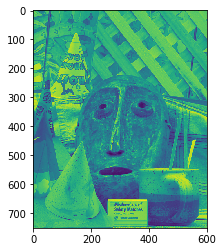

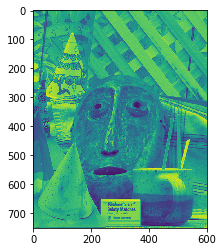

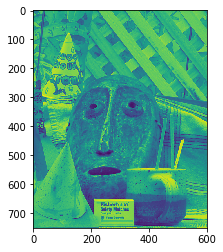

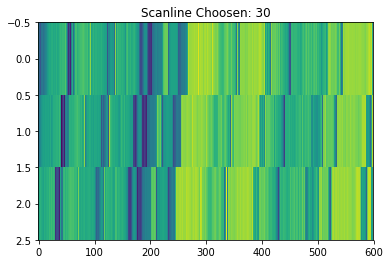

'\na = np.random.rand(3, 3)\na[0] = np.array([84, 150, 60])\na[1] = np.array([92, 13, 162])\na[2] =  np.array([21, 145, 52])\nplt.imshow(a)\n'

In [20]:
#Load image:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt


imgLeft = Image.open('./im4.ppm').convert('L')
imgMiddle = Image.open('./im5.ppm').convert('L')
imgRight = Image.open('./im6.ppm').convert('L')

a = imgLeft.size
print("original size of the figure: {}".format(a))
reshapeSize = (int(a[0]), int(a[1]))
print("We resize the figure in : {}".format(reshapeSize))

imgLeft = imgLeft.resize(reshapeSize, Image.ANTIALIAS)
imgMiddle = imgMiddle.resize(reshapeSize, Image.ANTIALIAS)
imgRight = imgRight.resize(reshapeSize, Image.ANTIALIAS)

numpyLeftImg = np.asarray(imgLeft)
numpyMiddleImg = np.asarray(imgMiddle)
numpyRightImg = np.asarray(imgRight)


numpyLeftImg = numpyLeftImg[:, 300:]
numpyMiddleImg = numpyMiddleImg[:, 300:]
numpyRightImg = numpyRightImg[:, 300:]



scanlineChoosen = 30


# Let's begin with a size of 100 for test

#numpyLeftImg = numpyLeftImg
#numpyMiddleImg = numpyMiddleImg
#numpyRightImg = numpyRightImg


#plt.figure()
#plt.subplot(311)
plt.imshow(numpyLeftImg)
plt.show()
#plt.subplot(312)
plt.imshow(numpyMiddleImg)
plt.show()
#plt.subplot(313)
plt.imshow(numpyRightImg)
plt.show()




a = np.full((3, numpyLeftImg.shape[1]), 0)
a[0, :] = numpyLeftImg[scanlineChoosen, :]
a[1, :] = numpyMiddleImg[scanlineChoosen, :]
a[2: ,:] = numpyRightImg[scanlineChoosen, :]
plt.title("Scanline Choosen: " + str(scanlineChoosen))
plt.imshow(a, interpolation='nearest', aspect='auto')
plt.show()




#a = np.random.rand(3, 9)
#a[0] = np.array([130, 150, 140, 0, 0, 10, 0, 0, 0])
#a[1] = np.array([0, 0, 0, 0, 120, 134, 162, 20, 7])
#a[2] =  np.array([50, 50, 50, 3, 15, 41, 115, 130, 152])
#plt.imshow(a)



"""
a = np.random.rand(3, 4)
a[0] = np.array([84, 150, 60, 21])
a[1] = np.array([92, 13, 72, 162])
a[2] =  np.array([21, 90, 148, 20])
plt.imshow(a)
"""

#With size 3, it works !
"""
a = np.random.rand(3, 3)
a[0] = np.array([84, 150, 60])
a[1] = np.array([92, 13, 162])
a[2] =  np.array([21, 145, 52])
plt.imshow(a)
"""


In [21]:
## The main 

#lenSequence = reshapeSize[0] + 1
lenSequence = 600
lenSequence += 1


print("I BEGIN TO LOAD")
#elementChoosen_history = cp.load("./lenSeq_" + str(lenSequence) + "/elementChoosen_history.npy")
indexPositionArray = cp.load("./lenSeq_" + str(lenSequence) + "/number_cells_computed.npy")
position_in_nw_flatten_matrix = cp.load("./lenSeq_" + str(lenSequence) + "/position_cells_to_compute.npy")

elementChoosen_history = cp.full((3*lenSequence**3, ), -1)
elementChoosen_history[:lenSequence**3] += position_in_nw_flatten_matrix // (lenSequence+1)**2
elementChoosen_history[lenSequence**3:2*lenSequence**3] += (position_in_nw_flatten_matrix // (lenSequence+1)) % (lenSequence+1)
elementChoosen_history[2*lenSequence**3:3*lenSequence**3] += position_in_nw_flatten_matrix % (lenSequence+1)
print("FINISH TO LOAD")


seq1 = numpyLeftImg[scanlineChoosen, :]
seq2 = numpyMiddleImg[scanlineChoosen, :]
seq3 = numpyRightImg[scanlineChoosen, :]




#seq1 = np.array([130, 150, 140, 30, 20, 10, 0, 0, 0])
#seq2 =np.array([0, 11, 19, 32, 120, 134, 162, 20, 7])
#seq3 = np.array([0, 0, 4, 3, 15, 41, 115, 130, 152])



#seq1 = a[0]
#seq2 = a[1]
#seq3 = a[2]




#print(seq1)
#print(seq2)
#print(seq3)

sequenceNumber1 = seq1
sequenceNumber2 = seq2
sequenceNumber3 = seq3



u1 = cp.empty((lenSequence, ), dtype=cp.int32)
u1[0] = 0 #-256*2-1
u1[1:] = cp.array(seq1)

u2 = cp.empty((lenSequence, ), dtype=cp.int32)
u2[0] = 0 #-256*3-1
u2[1:] = cp.array(seq2)

u3 = cp.empty((lenSequence, ), dtype=cp.int32)
u3[0] = 0 #-256*4-1
u3[1:] = cp.array(seq3)

#print(u1)
#print(u2)
#print(u3)

print(u1.shape)
print(u2.shape)
print(u3.shape)

print(u1)
print(u2)
print(u3)

I BEGIN TO LOAD
FINISH TO LOAD
(601,)
(601,)
(601,)
[  0 122 105  95  84  88 100 105 106 108 103 105 109 112 114 115 119 124
 128 133 137 138 137 136 141 140 141 138 137 135 139 134 137 144 142 136
 128 138 143 143 141 147 149 145 148 148 148 148 146 147 156 150 137 101
  50  66  83  85  84  62  48 114 139 116 102 109 131 150 152 152 143 143
 145 147 145 149 151 151 152 154 154 155 156 152 152 151 149 149 150 152
 145 140 144 149 168 170 134 118 139 139 144 140 139 142 143 142 142 139
 139 140 138 139 139 141 142 140 138 135 137 138 134 133 141 131 111  87
 102 118 112 116 127 128 130 130 125 130 127 105 101 170 169 129 146 150
 146 145 144 143 144 143 141 142 143 141 140 138 135 126 124 147 151 152
 149 140 140 147 144 137 138 139 139 141 143 144 138 138 137 133 131 128
 138 125  99  91  81  77  82  86  94 108 116 122 128 123 121 123 116  97
  75  69  71  72  71  75  66  65 102 105 100 110 108 113 115 117 115 111
 114 114 116 116 115 116 114 129 141 155 171 161 160 163 162 163 163 141

In [22]:
    start = time.time()

    print("COMPUTE SCORE MATRIX : ")
    #scoreMatrix, tempsPasseAtEachStep = computeScoringMatrix(u1, u2, u3)
    scoreMatrix, tempsPasseAtEachStep, index_max = computeScoringMatrix(u1, u2, u3)

    end = time.time()
    print("\nTemps passe pour calculer la matrice : {} secondes".format(end - start))

COMPUTE SCORE MATRIX : 
1801 / 1801
Temps passe pour calculer la matrice : 5.00803589821 secondes


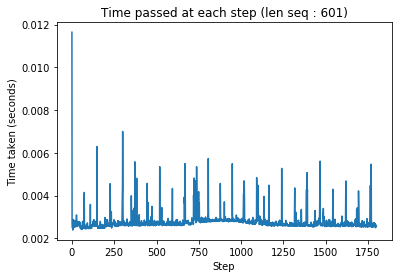

Mean : 0.002780548201666938
Var : 1.9432749511592486e-07


In [23]:
plt.plot(list(cp.arange(len(tempsPasseAtEachStep))), tempsPasseAtEachStep)
plt.title("Time passed at each step (len seq : " + str(lenSequence) + ")")
plt.xlabel("Step")
plt.ylabel("Time taken (seconds)")
plt.show()

arrayTempsPasseAtEachStep = cp.asarray(tempsPasseAtEachStep[:])
print("Mean : {}\nVar : {}".format(arrayTempsPasseAtEachStep.mean(), arrayTempsPasseAtEachStep.var()))


DETERMINATE PASS : 
ALIGN SEQUENCES : 
[122, 105, 95, 84, 88, 100, 105, 106, 108, 103, 105, 109, 112, 114, 115, 119, 124, 128, 133, 137, 138, 137, 136, 141, 140, 141, 138, 137, 135, 139, 134, 137, 144, 142, 136, 128, 138, 143, 143, 141, 147, 149, 145, 148, 148, 148, 148, 146, 147, 156, 150, 137, 101, 50, 66, 83, 85, 84, 62, 48, 114, 139, 116, 102, 109, 131, 150, 152, 152, 143, 143, 145, 147, 145, 149, 151, 151, 152, 154, 154, 155, 156, 152, 152, 151, 149, 149, 150, 152, 145, 140, 144, 149, 168, 170, 134, 118, 139, 139, 144, 140, 139, 142, 143, 142, 142, 139, 139, 140, 138, 139, 139, 141, 142, 140, 138, 135, 137, 138, 134, 133, 141, 131, 111, 87, '-', 102, 118, 112, 116, 127, 128, 130, 130, 125, 130, 127, 105, 101, 170, 169, 129, 146, 150, 146, 145, 144, 143, 144, 143, 141, 142, 143, 141, 140, 138, 135, 126, 124, 147, 151, 152, 149, 140, 140, 147, 144, 137, 138, 139, 139, 141, 143, 144, 138, 138, 137, 133, 131, 128, 138, 125, 99, 91, 81, 77, 82, 86, 94, 108, 116, 122, 128, 123, 121, 123

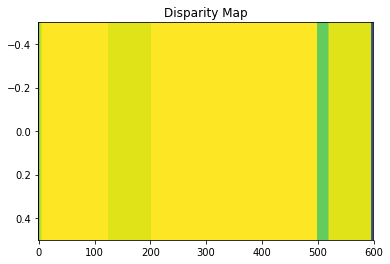

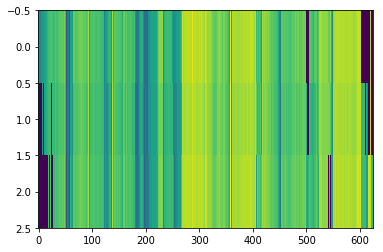

Len seq : 600


In [24]:
  #print(scoreMatrix)
  print("DETERMINATE PASS : ")
  #print(scoreMatrix.shape)
  path = determinatePath(cp.asnumpy(index_max))
  #path = determinatePath(cp.asnumpy(scoreMatrix), scoreMatrix.shape)
  
  #print(path)

  print("ALIGN SEQUENCES : ")
  S1final, S2final, S3final = alignSequences(seq1, seq2, seq3, path)
  print(S1final)
  print(S2final)
  print(S3final)
  
  DisparityMapS1 = []
  DisparityMapS2 = []
  DisparityMapS3 = []
  
 # print the align sequences:
  for i in range(len(S1final)):
    if (S1final[i] == '-'):
      S1final[i] = 0
    else:
      DisparityMapS1.append(i)
   # else:
   #   S1final[i] = int(S1final[i] / 2)

  for i in range(len(S2final)):
    if (S2final[i] == '-'):
      S2final[i] = 0
    else:
      DisparityMapS2.append(i)
    #else:
    #  S2final[i] = int(S2final[i] / 2)

  for i in range(len(S3final)):
    if (S3final[i] == '-'):
      S3final[i] = 0
    else:
      DisparityMapS3.append(i)
    #else:
    #  S3final[i] = int(S3final[i] / 2)
    
    
    
    
  #print("Disparity : ")
  #print(DisparityMapS1)
  #print(DisparityMapS2)
  #print(DisparityMapS3)
    
  DisparityMapS1 = np.array(DisparityMapS1)
  DisparityMapS2 = np.array(DisparityMapS2)
  DisparityMapS3 = np.array(DisparityMapS3)
  #distance = np.power(DisparityMapS1 - DisparityMapS2, 2) + np.power(DisparityMapS1 - DisparityMapS3, 2) + np.power(DisparityMapS2 - DisparityMapS3, 2)
  distance = np.abs(DisparityMapS1 - DisparityMapS2) + np.abs(DisparityMapS1 - DisparityMapS3) + np.abs(DisparityMapS2 - DisparityMapS3)

  print("Disparity : ")
  distance = distance.reshape((1, len(distance)))
  print(distance)
  plt.imshow(distance, interpolation='nearest', aspect='auto')
  plt.title("Disparity Map")
  plt.show()



  a = np.full((3, max(len(S1final), len(S2final), len(S3final))), 0)
  a[0, :len(S1final)] = np.array(S1final, dtype=np.int32)
  a[1, :len(S2final)] = S2final
  a[2:, :len(S3final)] = S3final
  plt.imshow(a, interpolation='nearest', aspect='auto')
  plt.show()
  print("Len seq : {}".format(len(seq1)))
  


I BEGIN TO LOAD
I FINISH TO LOAD
Scanline : 0 / 750
1801 / 1801

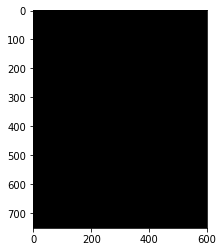

Scanline : 1 / 750
1801 / 1801Scanline : 2 / 750
1801 / 1801Scanline : 3 / 750
1801 / 1801Scanline : 4 / 750
1801 / 1801Scanline : 5 / 750
1801 / 1801Scanline : 6 / 750
1801 / 1801Scanline : 7 / 750
1801 / 1801Scanline : 8 / 750
1801 / 1801Scanline : 9 / 750
1801 / 1801Scanline : 10 / 750
1801 / 1801Scanline : 11 / 750
1801 / 1801Scanline : 12 / 750
1801 / 1801Scanline : 13 / 750
1801 / 1801Scanline : 14 / 750
1801 / 1801Scanline : 15 / 750
1801 / 1801Scanline : 16 / 750
1801 / 1801Scanline : 17 / 750
1801 / 1801Scanline : 18 / 750
1801 / 1801Scanline : 19 / 750
1801 / 1801Scanline : 20 / 750
1801 / 1801

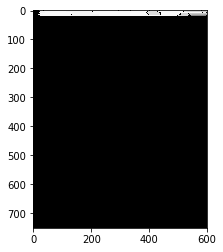

Scanline : 21 / 750
1801 / 1801Scanline : 22 / 750
1801 / 1801Scanline : 23 / 750
1801 / 1801Scanline : 24 / 750
1801 / 1801Scanline : 25 / 750
1801 / 1801Scanline : 26 / 750
1801 / 1801Scanline : 27 / 750
1801 / 1801Scanline : 28 / 750
1801 / 1801Scanline : 29 / 750
1801 / 1801Scanline : 30 / 750
1801 / 1801Scanline : 31 / 750
1801 / 1801Scanline : 32 / 750
1801 / 1801Scanline : 33 / 750
1801 / 1801Scanline : 34 / 750
1801 / 1801Scanline : 35 / 750
1801 / 1801Scanline : 36 / 750
1801 / 1801Scanline : 37 / 750
1801 / 1801Scanline : 38 / 750
1801 / 1801Scanline : 39 / 750
1801 / 1801Scanline : 40 / 750
1801 / 1801

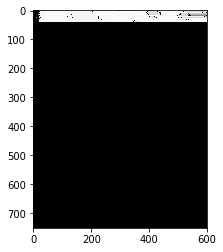

Scanline : 41 / 750
1801 / 1801Scanline : 42 / 750
1801 / 1801Scanline : 43 / 750
1801 / 1801Scanline : 44 / 750
1801 / 1801Scanline : 45 / 750
1801 / 1801Scanline : 46 / 750
1801 / 1801Scanline : 47 / 750
1801 / 1801Scanline : 48 / 750
1801 / 1801Scanline : 49 / 750
1801 / 1801Scanline : 50 / 750
1801 / 1801Scanline : 51 / 750
1801 / 1801Scanline : 52 / 750
1801 / 1801Scanline : 53 / 750
1801 / 1801Scanline : 54 / 750
1801 / 1801Scanline : 55 / 750
1801 / 1801Scanline : 56 / 750
1801 / 1801Scanline : 57 / 750
1801 / 1801Scanline : 58 / 750
1801 / 1801Scanline : 59 / 750
1801 / 1801Scanline : 60 / 750
1801 / 1801

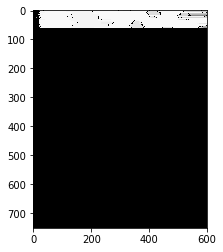

Scanline : 61 / 750
1801 / 1801Scanline : 62 / 750
1801 / 1801Scanline : 63 / 750
1801 / 1801Scanline : 64 / 750
1801 / 1801Scanline : 65 / 750
1801 / 1801Scanline : 66 / 750
1801 / 1801Scanline : 67 / 750
1801 / 1801Scanline : 68 / 750
1801 / 1801Scanline : 69 / 750
1801 / 1801Scanline : 70 / 750
1801 / 1801Scanline : 71 / 750
1801 / 1801Scanline : 72 / 750
1801 / 1801Scanline : 73 / 750
1801 / 1801Scanline : 74 / 750
1801 / 1801Scanline : 75 / 750
1801 / 1801Scanline : 76 / 750
1801 / 1801Scanline : 77 / 750
1801 / 1801Scanline : 78 / 750
1801 / 1801Scanline : 79 / 750
1801 / 1801Scanline : 80 / 750
1801 / 1801

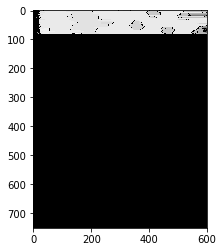

Scanline : 81 / 750
1801 / 1801Scanline : 82 / 750
1801 / 1801Scanline : 83 / 750
1801 / 1801Scanline : 84 / 750
1801 / 1801Scanline : 85 / 750
1801 / 1801Scanline : 86 / 750
1801 / 1801Scanline : 87 / 750
1801 / 1801Scanline : 88 / 750
1801 / 1801Scanline : 89 / 750
1801 / 1801Scanline : 90 / 750
1801 / 1801Scanline : 91 / 750
1801 / 1801Scanline : 92 / 750
1801 / 1801Scanline : 93 / 750
1801 / 1801Scanline : 94 / 750
1801 / 1801Scanline : 95 / 750
1801 / 1801Scanline : 96 / 750
1801 / 1801Scanline : 97 / 750
1801 / 1801Scanline : 98 / 750
1801 / 1801Scanline : 99 / 750
1801 / 1801Scanline : 100 / 750
1801 / 1801

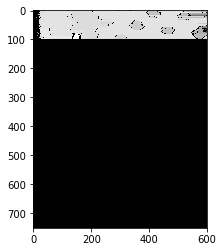

Scanline : 101 / 750
1801 / 1801Scanline : 102 / 750
1801 / 1801Scanline : 103 / 750
1801 / 1801Scanline : 104 / 750
1801 / 1801Scanline : 105 / 750
1801 / 1801Scanline : 106 / 750
1801 / 1801Scanline : 107 / 750
1801 / 1801Scanline : 108 / 750
1801 / 1801Scanline : 109 / 750
1801 / 1801Scanline : 110 / 750
1801 / 1801Scanline : 111 / 750
1801 / 1801Scanline : 112 / 750
1801 / 1801Scanline : 113 / 750
1801 / 1801Scanline : 114 / 750
1801 / 1801Scanline : 115 / 750
1801 / 1801Scanline : 116 / 750
1801 / 1801Scanline : 117 / 750
1801 / 1801Scanline : 118 / 750
1801 / 1801Scanline : 119 / 750
1801 / 1801Scanline : 120 / 750
1801 / 1801

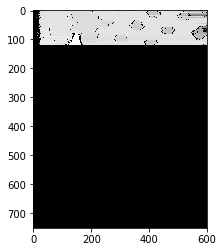

Scanline : 121 / 750
1801 / 1801Scanline : 122 / 750
1801 / 1801Scanline : 123 / 750
1801 / 1801Scanline : 124 / 750
1801 / 1801Scanline : 125 / 750
1801 / 1801Scanline : 126 / 750
1801 / 1801Scanline : 127 / 750
1801 / 1801Scanline : 128 / 750
1801 / 1801Scanline : 129 / 750
1801 / 1801Scanline : 130 / 750
1801 / 1801Scanline : 131 / 750
1801 / 1801Scanline : 132 / 750
1801 / 1801Scanline : 133 / 750
1801 / 1801Scanline : 134 / 750
1801 / 1801Scanline : 135 / 750
1801 / 1801Scanline : 136 / 750
1801 / 1801Scanline : 137 / 750
1801 / 1801Scanline : 138 / 750
1801 / 1801Scanline : 139 / 750
1801 / 1801Scanline : 140 / 750
1801 / 1801

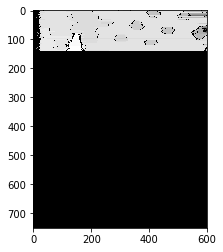

Scanline : 141 / 750
1801 / 1801Scanline : 142 / 750
1801 / 1801Scanline : 143 / 750
1801 / 1801Scanline : 144 / 750
1801 / 1801Scanline : 145 / 750
1801 / 1801Scanline : 146 / 750
1801 / 1801Scanline : 147 / 750
1801 / 1801Scanline : 148 / 750
1801 / 1801Scanline : 149 / 750
1801 / 1801Scanline : 150 / 750
1801 / 1801Scanline : 151 / 750
1801 / 1801Scanline : 152 / 750
1801 / 1801Scanline : 153 / 750
1801 / 1801Scanline : 154 / 750
1801 / 1801Scanline : 155 / 750
1801 / 1801Scanline : 156 / 750
1801 / 1801Scanline : 157 / 750
1801 / 1801Scanline : 158 / 750
1801 / 1801Scanline : 159 / 750
1801 / 1801Scanline : 160 / 750
1801 / 1801

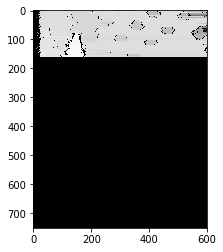

Scanline : 161 / 750
1801 / 1801Scanline : 162 / 750
1801 / 1801Scanline : 163 / 750
1801 / 1801Scanline : 164 / 750
1801 / 1801Scanline : 165 / 750
1801 / 1801Scanline : 166 / 750
1801 / 1801Scanline : 167 / 750
1801 / 1801Scanline : 168 / 750
1801 / 1801Scanline : 169 / 750
1801 / 1801Scanline : 170 / 750
1801 / 1801Scanline : 171 / 750
1801 / 1801Scanline : 172 / 750
1801 / 1801Scanline : 173 / 750
1801 / 1801Scanline : 174 / 750
1801 / 1801Scanline : 175 / 750
1801 / 1801Scanline : 176 / 750
1801 / 1801Scanline : 177 / 750
1801 / 1801Scanline : 178 / 750
1801 / 1801Scanline : 179 / 750
1801 / 1801Scanline : 180 / 750
1801 / 1801

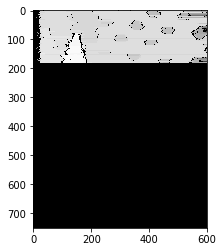

Scanline : 181 / 750
1801 / 1801Scanline : 182 / 750
1801 / 1801Scanline : 183 / 750
1801 / 1801Scanline : 184 / 750
1801 / 1801Scanline : 185 / 750
1801 / 1801Scanline : 186 / 750
1801 / 1801Scanline : 187 / 750
1801 / 1801Scanline : 188 / 750
1801 / 1801Scanline : 189 / 750
1801 / 1801Scanline : 190 / 750
1801 / 1801Scanline : 191 / 750
1801 / 1801Scanline : 192 / 750
1801 / 1801Scanline : 193 / 750
1801 / 1801Scanline : 194 / 750
1801 / 1801Scanline : 195 / 750
1801 / 1801Scanline : 196 / 750
1801 / 1801Scanline : 197 / 750
1801 / 1801Scanline : 198 / 750
1801 / 1801Scanline : 199 / 750
1801 / 1801Scanline : 200 / 750
1801 / 1801

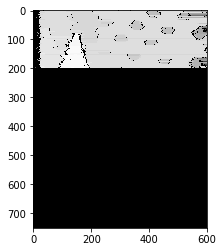

Scanline : 201 / 750
1801 / 1801Scanline : 202 / 750
1801 / 1801Scanline : 203 / 750
1801 / 1801Scanline : 204 / 750
1801 / 1801Scanline : 205 / 750
1801 / 1801Scanline : 206 / 750
1801 / 1801Scanline : 207 / 750
1801 / 1801Scanline : 208 / 750
1801 / 1801Scanline : 209 / 750
1801 / 1801Scanline : 210 / 750
1801 / 1801Scanline : 211 / 750
1801 / 1801Scanline : 212 / 750
1801 / 1801Scanline : 213 / 750
1801 / 1801Scanline : 214 / 750
1801 / 1801Scanline : 215 / 750
1801 / 1801Scanline : 216 / 750
1801 / 1801Scanline : 217 / 750
1801 / 1801Scanline : 218 / 750
1801 / 1801Scanline : 219 / 750
1801 / 1801Scanline : 220 / 750
1801 / 1801

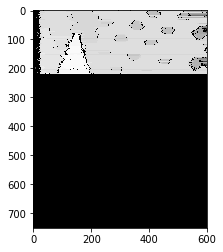

Scanline : 221 / 750
1801 / 1801Scanline : 222 / 750
1801 / 1801Scanline : 223 / 750
1801 / 1801Scanline : 224 / 750
1801 / 1801Scanline : 225 / 750
1801 / 1801Scanline : 226 / 750
1801 / 1801Scanline : 227 / 750
1801 / 1801Scanline : 228 / 750
1801 / 1801Scanline : 229 / 750
1801 / 1801Scanline : 230 / 750
1801 / 1801Scanline : 231 / 750
1801 / 1801Scanline : 232 / 750
1801 / 1801Scanline : 233 / 750
1801 / 1801Scanline : 234 / 750
1801 / 1801Scanline : 235 / 750
1801 / 1801Scanline : 236 / 750
1801 / 1801Scanline : 237 / 750
1801 / 1801Scanline : 238 / 750
1801 / 1801Scanline : 239 / 750
1801 / 1801Scanline : 240 / 750
1801 / 1801

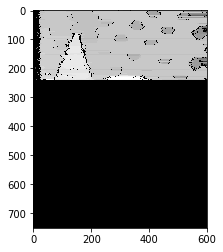

Scanline : 241 / 750
1801 / 1801Scanline : 242 / 750
1801 / 1801Scanline : 243 / 750
1801 / 1801Scanline : 244 / 750
1801 / 1801Scanline : 245 / 750
1801 / 1801Scanline : 246 / 750
1801 / 1801Scanline : 247 / 750
1801 / 1801Scanline : 248 / 750
1801 / 1801Scanline : 249 / 750
1801 / 1801Scanline : 250 / 750
1801 / 1801Scanline : 251 / 750
1801 / 1801Scanline : 252 / 750
1801 / 1801Scanline : 253 / 750
1801 / 1801Scanline : 254 / 750
1801 / 1801Scanline : 255 / 750
1801 / 1801Scanline : 256 / 750
1801 / 1801Scanline : 257 / 750
1801 / 1801Scanline : 258 / 750
1801 / 1801Scanline : 259 / 750
1801 / 1801Scanline : 260 / 750
1801 / 1801

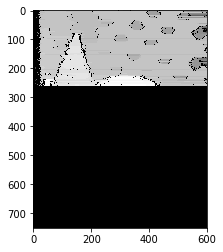

Scanline : 261 / 750
1801 / 1801Scanline : 262 / 750
1801 / 1801Scanline : 263 / 750
1801 / 1801Scanline : 264 / 750
1801 / 1801Scanline : 265 / 750
1801 / 1801Scanline : 266 / 750
1801 / 1801Scanline : 267 / 750
1801 / 1801Scanline : 268 / 750
1801 / 1801Scanline : 269 / 750
1801 / 1801Scanline : 270 / 750
1801 / 1801Scanline : 271 / 750
1801 / 1801Scanline : 272 / 750
1801 / 1801Scanline : 273 / 750
1801 / 1801Scanline : 274 / 750
1801 / 1801Scanline : 275 / 750
1801 / 1801Scanline : 276 / 750
1801 / 1801Scanline : 277 / 750
1801 / 1801Scanline : 278 / 750
1801 / 1801Scanline : 279 / 750
1801 / 1801Scanline : 280 / 750
1801 / 1801

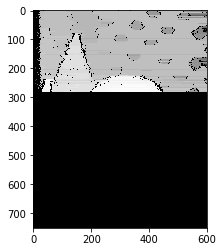

Scanline : 281 / 750
1801 / 1801Scanline : 282 / 750
1801 / 1801Scanline : 283 / 750
1801 / 1801Scanline : 284 / 750
1801 / 1801Scanline : 285 / 750
1801 / 1801Scanline : 286 / 750
1801 / 1801Scanline : 287 / 750
1801 / 1801Scanline : 288 / 750
1801 / 1801Scanline : 289 / 750
1801 / 1801Scanline : 290 / 750
1801 / 1801Scanline : 291 / 750
1801 / 1801Scanline : 292 / 750
1801 / 1801Scanline : 293 / 750
1801 / 1801Scanline : 294 / 750
1801 / 1801Scanline : 295 / 750
1801 / 1801Scanline : 296 / 750
1801 / 1801Scanline : 297 / 750
1801 / 1801Scanline : 298 / 750
1801 / 1801Scanline : 299 / 750
1801 / 1801Scanline : 300 / 750
1801 / 1801

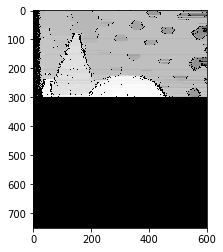

Scanline : 301 / 750
1801 / 1801Scanline : 302 / 750
1801 / 1801Scanline : 303 / 750
1801 / 1801Scanline : 304 / 750
1801 / 1801Scanline : 305 / 750
1801 / 1801Scanline : 306 / 750
1801 / 1801Scanline : 307 / 750
1801 / 1801Scanline : 308 / 750
1801 / 1801Scanline : 309 / 750
1801 / 1801Scanline : 310 / 750
1801 / 1801Scanline : 311 / 750
1801 / 1801Scanline : 312 / 750
1801 / 1801Scanline : 313 / 750
1801 / 1801Scanline : 314 / 750
1801 / 1801Scanline : 315 / 750
1801 / 1801Scanline : 316 / 750
1801 / 1801Scanline : 317 / 750
1801 / 1801Scanline : 318 / 750
1801 / 1801Scanline : 319 / 750
1801 / 1801Scanline : 320 / 750
1801 / 1801

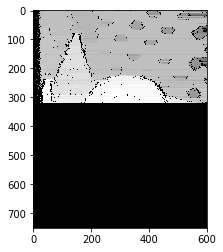

Scanline : 321 / 750
1801 / 1801Scanline : 322 / 750
1801 / 1801Scanline : 323 / 750
1801 / 1801Scanline : 324 / 750
1801 / 1801Scanline : 325 / 750
1801 / 1801Scanline : 326 / 750
1801 / 1801Scanline : 327 / 750
1801 / 1801Scanline : 328 / 750
1801 / 1801Scanline : 329 / 750
1801 / 1801Scanline : 330 / 750
1801 / 1801Scanline : 331 / 750
1801 / 1801Scanline : 332 / 750
1801 / 1801Scanline : 333 / 750
1801 / 1801Scanline : 334 / 750
1801 / 1801Scanline : 335 / 750
1801 / 1801Scanline : 336 / 750
1801 / 1801Scanline : 337 / 750
1801 / 1801Scanline : 338 / 750
1801 / 1801Scanline : 339 / 750
1801 / 1801Scanline : 340 / 750
1801 / 1801

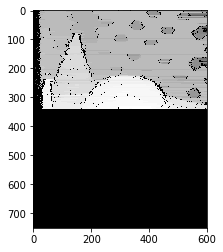

Scanline : 341 / 750
1801 / 1801Scanline : 342 / 750
1801 / 1801Scanline : 343 / 750
1801 / 1801Scanline : 344 / 750
1801 / 1801Scanline : 345 / 750
1801 / 1801Scanline : 346 / 750
1801 / 1801Scanline : 347 / 750
1801 / 1801Scanline : 348 / 750
1801 / 1801Scanline : 349 / 750
1801 / 1801Scanline : 350 / 750
1801 / 1801Scanline : 351 / 750
1801 / 1801Scanline : 352 / 750
1801 / 1801Scanline : 353 / 750
1801 / 1801Scanline : 354 / 750
1801 / 1801Scanline : 355 / 750
1801 / 1801Scanline : 356 / 750
1801 / 1801Scanline : 357 / 750
1801 / 1801Scanline : 358 / 750
1801 / 1801Scanline : 359 / 750
1801 / 1801Scanline : 360 / 750
1801 / 1801

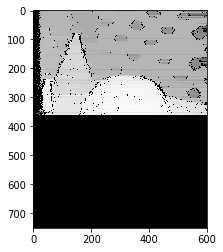

Scanline : 361 / 750
1801 / 1801Scanline : 362 / 750
1801 / 1801Scanline : 363 / 750
1801 / 1801Scanline : 364 / 750
1801 / 1801Scanline : 365 / 750
1801 / 1801Scanline : 366 / 750
1801 / 1801Scanline : 367 / 750
1801 / 1801Scanline : 368 / 750
1801 / 1801Scanline : 369 / 750
1801 / 1801Scanline : 370 / 750
1801 / 1801Scanline : 371 / 750
1801 / 1801Scanline : 372 / 750
1801 / 1801Scanline : 373 / 750
1801 / 1801Scanline : 374 / 750
1801 / 1801Scanline : 375 / 750
1801 / 1801Scanline : 376 / 750
1801 / 1801Scanline : 377 / 750
1801 / 1801Scanline : 378 / 750
1801 / 1801Scanline : 379 / 750
1801 / 1801Scanline : 380 / 750
1801 / 1801

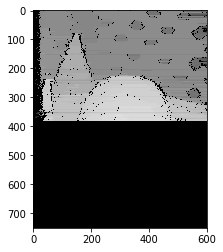

Scanline : 381 / 750
1801 / 1801Scanline : 382 / 750
1801 / 1801Scanline : 383 / 750
1801 / 1801Scanline : 384 / 750
1801 / 1801Scanline : 385 / 750
1801 / 1801Scanline : 386 / 750
1801 / 1801Scanline : 387 / 750
1801 / 1801Scanline : 388 / 750
1801 / 1801Scanline : 389 / 750
1801 / 1801Scanline : 390 / 750
1801 / 1801Scanline : 391 / 750
1801 / 1801Scanline : 392 / 750
1801 / 1801Scanline : 393 / 750
1801 / 1801Scanline : 394 / 750
1801 / 1801Scanline : 395 / 750
1801 / 1801Scanline : 396 / 750
1801 / 1801Scanline : 397 / 750
1801 / 1801Scanline : 398 / 750
1801 / 1801Scanline : 399 / 750
1801 / 1801Scanline : 400 / 750
1801 / 1801

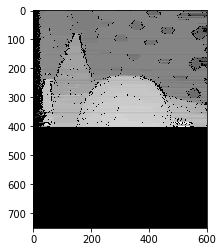

Scanline : 401 / 750
1801 / 1801Scanline : 402 / 750
1801 / 1801Scanline : 403 / 750
1801 / 1801Scanline : 404 / 750
1801 / 1801Scanline : 405 / 750
1801 / 1801Scanline : 406 / 750
1801 / 1801Scanline : 407 / 750
1801 / 1801Scanline : 408 / 750
1801 / 1801Scanline : 409 / 750
1801 / 1801Scanline : 410 / 750
1801 / 1801Scanline : 411 / 750
1801 / 1801Scanline : 412 / 750
1801 / 1801Scanline : 413 / 750
1801 / 1801Scanline : 414 / 750
1801 / 1801Scanline : 415 / 750
1801 / 1801Scanline : 416 / 750
1801 / 1801Scanline : 417 / 750
1801 / 1801Scanline : 418 / 750
1801 / 1801Scanline : 419 / 750
1801 / 1801Scanline : 420 / 750
1801 / 1801

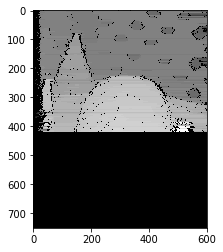

Scanline : 421 / 750
1801 / 1801Scanline : 422 / 750
1801 / 1801Scanline : 423 / 750
1801 / 1801Scanline : 424 / 750
1801 / 1801Scanline : 425 / 750
1801 / 1801Scanline : 426 / 750
1801 / 1801Scanline : 427 / 750
1801 / 1801Scanline : 428 / 750
1801 / 1801Scanline : 429 / 750
1801 / 1801Scanline : 430 / 750
1801 / 1801Scanline : 431 / 750
1801 / 1801Scanline : 432 / 750
1801 / 1801Scanline : 433 / 750
1801 / 1801Scanline : 434 / 750
1801 / 1801Scanline : 435 / 750
1801 / 1801Scanline : 436 / 750
1801 / 1801Scanline : 437 / 750
1801 / 1801Scanline : 438 / 750
1801 / 1801Scanline : 439 / 750
1801 / 1801Scanline : 440 / 750
1801 / 1801

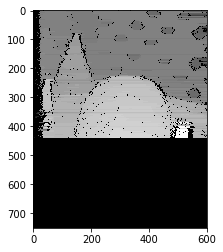

Scanline : 441 / 750
1801 / 1801Scanline : 442 / 750
1801 / 1801Scanline : 443 / 750
1801 / 1801Scanline : 444 / 750
1801 / 1801Scanline : 445 / 750
1801 / 1801Scanline : 446 / 750
1801 / 1801Scanline : 447 / 750
1801 / 1801Scanline : 448 / 750
1801 / 1801Scanline : 449 / 750
1801 / 1801Scanline : 450 / 750
1801 / 1801Scanline : 451 / 750
1801 / 1801Scanline : 452 / 750
1801 / 1801Scanline : 453 / 750
1801 / 1801Scanline : 454 / 750
1801 / 1801Scanline : 455 / 750
1801 / 1801Scanline : 456 / 750
1801 / 1801Scanline : 457 / 750
1801 / 1801Scanline : 458 / 750
1801 / 1801Scanline : 459 / 750
1801 / 1801Scanline : 460 / 750
1801 / 1801

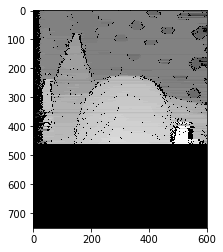

Scanline : 461 / 750
1801 / 1801Scanline : 462 / 750
1801 / 1801Scanline : 463 / 750
1801 / 1801Scanline : 464 / 750
1801 / 1801Scanline : 465 / 750
1801 / 1801Scanline : 466 / 750
1801 / 1801Scanline : 467 / 750
1801 / 1801Scanline : 468 / 750
1801 / 1801Scanline : 469 / 750
1801 / 1801Scanline : 470 / 750
1801 / 1801Scanline : 471 / 750
1801 / 1801Scanline : 472 / 750
1801 / 1801Scanline : 473 / 750
1801 / 1801Scanline : 474 / 750
1801 / 1801Scanline : 475 / 750
1801 / 1801Scanline : 476 / 750
1801 / 1801Scanline : 477 / 750
1801 / 1801Scanline : 478 / 750
1801 / 1801Scanline : 479 / 750
1801 / 1801Scanline : 480 / 750
1801 / 1801

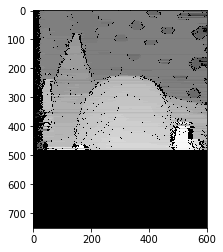

Scanline : 481 / 750
1801 / 1801Scanline : 482 / 750
1801 / 1801Scanline : 483 / 750
1801 / 1801Scanline : 484 / 750
1801 / 1801Scanline : 485 / 750
1801 / 1801Scanline : 486 / 750
1801 / 1801Scanline : 487 / 750
1801 / 1801Scanline : 488 / 750
1801 / 1801Scanline : 489 / 750
1801 / 1801Scanline : 490 / 750
1801 / 1801Scanline : 491 / 750
1801 / 1801Scanline : 492 / 750
1801 / 1801Scanline : 493 / 750
1801 / 1801Scanline : 494 / 750
1801 / 1801Scanline : 495 / 750
1801 / 1801Scanline : 496 / 750
1801 / 1801Scanline : 497 / 750
1801 / 1801Scanline : 498 / 750
1801 / 1801Scanline : 499 / 750
1801 / 1801Scanline : 500 / 750
1801 / 1801

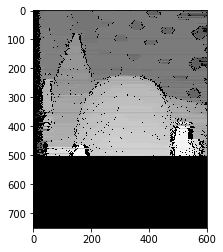

Scanline : 501 / 750
1801 / 1801Scanline : 502 / 750
1801 / 1801Scanline : 503 / 750
1801 / 1801Scanline : 504 / 750
1801 / 1801Scanline : 505 / 750
1801 / 1801Scanline : 506 / 750
1801 / 1801Scanline : 507 / 750
1801 / 1801Scanline : 508 / 750
1801 / 1801Scanline : 509 / 750
1801 / 1801Scanline : 510 / 750
1801 / 1801Scanline : 511 / 750
1801 / 1801Scanline : 512 / 750
1801 / 1801Scanline : 513 / 750
1801 / 1801Scanline : 514 / 750
1801 / 1801Scanline : 515 / 750
1801 / 1801Scanline : 516 / 750
1801 / 1801Scanline : 517 / 750
1801 / 1801Scanline : 518 / 750
1801 / 1801Scanline : 519 / 750
1801 / 1801Scanline : 520 / 750
1801 / 1801

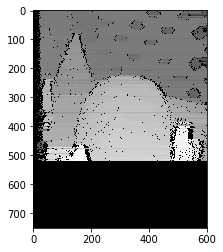

Scanline : 521 / 750
1801 / 1801Scanline : 522 / 750
1801 / 1801Scanline : 523 / 750
1801 / 1801Scanline : 524 / 750
1801 / 1801Scanline : 525 / 750
1801 / 1801Scanline : 526 / 750
1801 / 1801Scanline : 527 / 750
1801 / 1801Scanline : 528 / 750
1801 / 1801Scanline : 529 / 750
1801 / 1801Scanline : 530 / 750
1801 / 1801Scanline : 531 / 750
1801 / 1801Scanline : 532 / 750
1801 / 1801Scanline : 533 / 750
1801 / 1801Scanline : 534 / 750
1801 / 1801Scanline : 535 / 750
1801 / 1801Scanline : 536 / 750
1801 / 1801Scanline : 537 / 750
1801 / 1801Scanline : 538 / 750
1801 / 1801Scanline : 539 / 750
1801 / 1801Scanline : 540 / 750
1801 / 1801

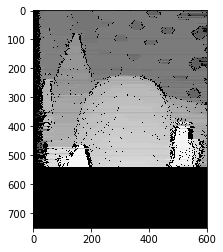

Scanline : 541 / 750
1801 / 1801Scanline : 542 / 750
1801 / 1801Scanline : 543 / 750
1801 / 1801Scanline : 544 / 750
1801 / 1801Scanline : 545 / 750
1801 / 1801Scanline : 546 / 750
1801 / 1801Scanline : 547 / 750
1801 / 1801Scanline : 548 / 750
1801 / 1801Scanline : 549 / 750
1801 / 1801Scanline : 550 / 750
1801 / 1801Scanline : 551 / 750
1801 / 1801Scanline : 552 / 750
1801 / 1801Scanline : 553 / 750
1801 / 1801Scanline : 554 / 750
1801 / 1801Scanline : 555 / 750
1801 / 1801Scanline : 556 / 750
1801 / 1801Scanline : 557 / 750
1801 / 1801Scanline : 558 / 750
1801 / 1801Scanline : 559 / 750
1801 / 1801Scanline : 560 / 750
1801 / 1801

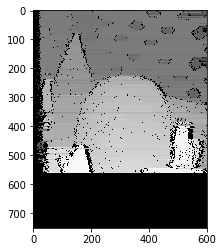

Scanline : 561 / 750
1801 / 1801Scanline : 562 / 750
1801 / 1801Scanline : 563 / 750
1801 / 1801Scanline : 564 / 750
1801 / 1801Scanline : 565 / 750
1801 / 1801Scanline : 566 / 750
1801 / 1801Scanline : 567 / 750
1801 / 1801Scanline : 568 / 750
1801 / 1801Scanline : 569 / 750
1801 / 1801Scanline : 570 / 750
1801 / 1801Scanline : 571 / 750
1801 / 1801Scanline : 572 / 750
1801 / 1801Scanline : 573 / 750
1801 / 1801Scanline : 574 / 750
1801 / 1801Scanline : 575 / 750
1801 / 1801Scanline : 576 / 750
1801 / 1801Scanline : 577 / 750
1801 / 1801Scanline : 578 / 750
1801 / 1801Scanline : 579 / 750
1801 / 1801Scanline : 580 / 750
1801 / 1801

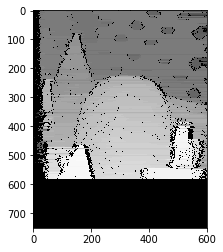

Scanline : 581 / 750
1801 / 1801Scanline : 582 / 750
1801 / 1801Scanline : 583 / 750
1801 / 1801Scanline : 584 / 750
1801 / 1801Scanline : 585 / 750
1801 / 1801Scanline : 586 / 750
1801 / 1801Scanline : 587 / 750
1801 / 1801Scanline : 588 / 750
1801 / 1801Scanline : 589 / 750
1801 / 1801Scanline : 590 / 750
1801 / 1801Scanline : 591 / 750
1801 / 1801Scanline : 592 / 750
1801 / 1801Scanline : 593 / 750
1801 / 1801Scanline : 594 / 750
1801 / 1801Scanline : 595 / 750
1801 / 1801Scanline : 596 / 750
1801 / 1801Scanline : 597 / 750
1801 / 1801Scanline : 598 / 750
1801 / 1801Scanline : 599 / 750
1801 / 1801Scanline : 600 / 750
1801 / 1801

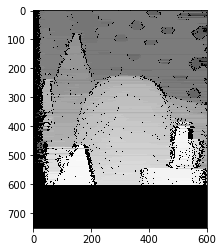

Scanline : 601 / 750
1801 / 1801Scanline : 602 / 750
1801 / 1801Scanline : 603 / 750
1801 / 1801Scanline : 604 / 750
1801 / 1801Scanline : 605 / 750
1801 / 1801Scanline : 606 / 750
1801 / 1801Scanline : 607 / 750
1801 / 1801Scanline : 608 / 750
1801 / 1801Scanline : 609 / 750
1801 / 1801Scanline : 610 / 750
1801 / 1801Scanline : 611 / 750
1801 / 1801Scanline : 612 / 750
1801 / 1801Scanline : 613 / 750
1801 / 1801Scanline : 614 / 750
1801 / 1801Scanline : 615 / 750
1801 / 1801Scanline : 616 / 750
1801 / 1801Scanline : 617 / 750
1801 / 1801Scanline : 618 / 750
1801 / 1801Scanline : 619 / 750
1801 / 1801Scanline : 620 / 750
1801 / 1801

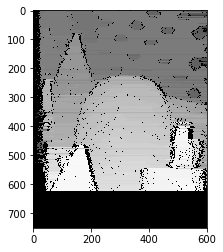

Scanline : 621 / 750
1801 / 1801Scanline : 622 / 750
1801 / 1801Scanline : 623 / 750
1801 / 1801Scanline : 624 / 750
1801 / 1801Scanline : 625 / 750
1801 / 1801Scanline : 626 / 750
1801 / 1801Scanline : 627 / 750
1801 / 1801Scanline : 628 / 750
1801 / 1801Scanline : 629 / 750
1801 / 1801Scanline : 630 / 750
1801 / 1801Scanline : 631 / 750
1801 / 1801Scanline : 632 / 750
1801 / 1801Scanline : 633 / 750
1801 / 1801Scanline : 634 / 750
1801 / 1801Scanline : 635 / 750
1801 / 1801Scanline : 636 / 750
1801 / 1801Scanline : 637 / 750
1801 / 1801Scanline : 638 / 750
1801 / 1801Scanline : 639 / 750
1801 / 1801Scanline : 640 / 750
1801 / 1801

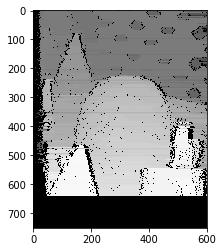

Scanline : 641 / 750
1801 / 1801Scanline : 642 / 750
1801 / 1801Scanline : 643 / 750
1801 / 1801Scanline : 644 / 750
1801 / 1801Scanline : 645 / 750
1801 / 1801Scanline : 646 / 750
1801 / 1801Scanline : 647 / 750
1801 / 1801Scanline : 648 / 750
1801 / 1801Scanline : 649 / 750
1801 / 1801Scanline : 650 / 750
1801 / 1801Scanline : 651 / 750
1801 / 1801Scanline : 652 / 750
1801 / 1801Scanline : 653 / 750
1801 / 1801Scanline : 654 / 750
1801 / 1801Scanline : 655 / 750
1801 / 1801Scanline : 656 / 750
1801 / 1801Scanline : 657 / 750
1801 / 1801Scanline : 658 / 750
1801 / 1801Scanline : 659 / 750
1801 / 1801Scanline : 660 / 750
1801 / 1801

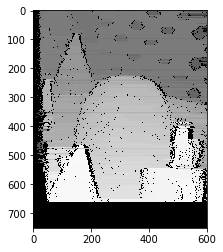

Scanline : 661 / 750
1801 / 1801Scanline : 662 / 750
1801 / 1801Scanline : 663 / 750
1801 / 1801Scanline : 664 / 750
1801 / 1801Scanline : 665 / 750
1801 / 1801Scanline : 666 / 750
1801 / 1801Scanline : 667 / 750
1801 / 1801Scanline : 668 / 750
1801 / 1801Scanline : 669 / 750
1801 / 1801Scanline : 670 / 750
1801 / 1801Scanline : 671 / 750
1801 / 1801Scanline : 672 / 750
1801 / 1801Scanline : 673 / 750
1801 / 1801Scanline : 674 / 750
1801 / 1801Scanline : 675 / 750
1801 / 1801Scanline : 676 / 750
1801 / 1801Scanline : 677 / 750
1801 / 1801Scanline : 678 / 750
1801 / 1801Scanline : 679 / 750
1801 / 1801Scanline : 680 / 750
1801 / 1801

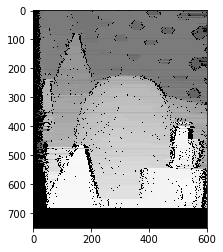

Scanline : 681 / 750
1801 / 1801Scanline : 682 / 750
1801 / 1801Scanline : 683 / 750
1801 / 1801Scanline : 684 / 750
1801 / 1801Scanline : 685 / 750
1801 / 1801Scanline : 686 / 750
1801 / 1801Scanline : 687 / 750
1801 / 1801Scanline : 688 / 750
1801 / 1801Scanline : 689 / 750
1801 / 1801Scanline : 690 / 750
1801 / 1801Scanline : 691 / 750
1801 / 1801Scanline : 692 / 750
1801 / 1801Scanline : 693 / 750
1801 / 1801Scanline : 694 / 750
1801 / 1801Scanline : 695 / 750
1801 / 1801Scanline : 696 / 750
1801 / 1801Scanline : 697 / 750
1801 / 1801Scanline : 698 / 750
1801 / 1801Scanline : 699 / 750
1801 / 1801Scanline : 700 / 750
1801 / 1801

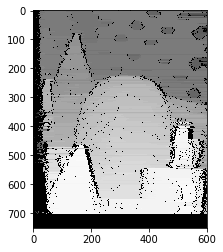

Scanline : 701 / 750
1801 / 1801Scanline : 702 / 750
1801 / 1801Scanline : 703 / 750
1801 / 1801Scanline : 704 / 750
1801 / 1801Scanline : 705 / 750
1801 / 1801Scanline : 706 / 750
1801 / 1801Scanline : 707 / 750
1801 / 1801Scanline : 708 / 750
1801 / 1801Scanline : 709 / 750
1801 / 1801Scanline : 710 / 750
1801 / 1801Scanline : 711 / 750
1801 / 1801Scanline : 712 / 750
1801 / 1801Scanline : 713 / 750
1801 / 1801Scanline : 714 / 750
1801 / 1801Scanline : 715 / 750
1801 / 1801Scanline : 716 / 750
1801 / 1801Scanline : 717 / 750
1801 / 1801Scanline : 718 / 750
1801 / 1801Scanline : 719 / 750
1801 / 1801Scanline : 720 / 750
1801 / 1801

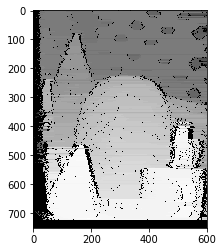

Scanline : 721 / 750
1801 / 1801Scanline : 722 / 750
1801 / 1801Scanline : 723 / 750
1801 / 1801Scanline : 724 / 750
1801 / 1801Scanline : 725 / 750
1801 / 1801Scanline : 726 / 750
1801 / 1801Scanline : 727 / 750
1801 / 1801Scanline : 728 / 750
1801 / 1801Scanline : 729 / 750
1801 / 1801Scanline : 730 / 750
1801 / 1801Scanline : 731 / 750
1801 / 1801Scanline : 732 / 750
1801 / 1801Scanline : 733 / 750
1801 / 1801Scanline : 734 / 750
1801 / 1801Scanline : 735 / 750
1801 / 1801Scanline : 736 / 750
1801 / 1801Scanline : 737 / 750
1801 / 1801Scanline : 738 / 750
1801 / 1801Scanline : 739 / 750
1801 / 1801Scanline : 740 / 750
1801 / 1801

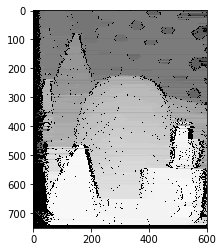

Scanline : 741 / 750
1801 / 1801Scanline : 742 / 750
1801 / 1801Scanline : 743 / 750
1801 / 1801Scanline : 744 / 750
1801 / 1801Scanline : 745 / 750
1801 / 1801Scanline : 746 / 750
1801 / 1801Scanline : 747 / 750
1801 / 1801Scanline : 748 / 750
1801 / 1801Scanline : 749 / 750
1801 / 1801

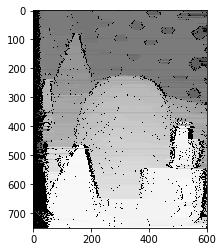

Time taken : 4063.27444005 secs


In [17]:
numberScanLine = reshapeSize[1]
#lenSequence = reshapeSize[0] + 1
lenSequence = 600 # Enter le len of the sequence here
lenSequence += 1


print("I BEGIN TO LOAD")
#elementChoosen_history = cp.load("./lenSeq_" + str(lenSequence) + "/elementChoosen_history.npy")
indexPositionArray = cp.load("./lenSeq_" + str(lenSequence) + "/number_cells_computed.npy")
position_in_nw_flatten_matrix = cp.load("./lenSeq_" + str(lenSequence) + "/position_cells_to_compute.npy")

elementChoosen_history = cp.full((3*lenSequence**3, ), -1)
elementChoosen_history[:lenSequence**3] += position_in_nw_flatten_matrix // (lenSequence+1)**2
elementChoosen_history[lenSequence**3:2*lenSequence**3] += (position_in_nw_flatten_matrix // (lenSequence+1)) % (lenSequence+1)
elementChoosen_history[2*lenSequence**3:3*lenSequence**3] += position_in_nw_flatten_matrix % (lenSequence+1)
print("I FINISH TO LOAD")




disparityMap = np.zeros((numberScanLine, lenSequence-1))
disparityMap2 = np.zeros((numberScanLine, lenSequence-1))
disparityMap3 = np.zeros((numberScanLine, lenSequence-1))
disparityMap4 = np.zeros((numberScanLine, lenSequence-1))
disparityMap5 = np.zeros((numberScanLine, lenSequence-1))
begin_compute = time.time()
for k in range(numberScanLine):
  print("Scanline : {} / {}".format(k, numberScanLine))
  scanlineChoosen = k
  seq1 = numpyLeftImg[scanlineChoosen, :]
  seq2 = numpyMiddleImg[scanlineChoosen, :]
  seq3 = numpyRightImg[scanlineChoosen, :]
  sequenceNumber1 = seq1
  sequenceNumber2 = seq2
  sequenceNumber3 = seq3



  u1 = cp.empty((lenSequence, ), dtype=cp.int32)
  u1[0] = 0 #-256*2-1
  u1[1:] = cp.array(seq1)

  u2 = cp.empty((lenSequence, ), dtype=cp.int32)
  u2[0] = 0 #-256*3-1
  u2[1:] = cp.array(seq2)

  u3 = cp.empty((lenSequence, ), dtype=cp.int32)
  u3[0] = 0 #-256*4-1
  u3[1:] = cp.array(seq3)
  
  #scoreMatrix, tempsPasseAtEachStep = computeScoringMatrix(u1, u2, u3)
  scoreMatrix, tempsPasseAtEachStep, index_max = computeScoringMatrix(u1, u2, u3)

  #path = determinatePath(cp.asnumpy(scoreMatrix), scoreMatrix.shape)
  path = determinatePath(cp.asnumpy(index_max))
  S1final, S2final, S3final = alignSequences(seq1, seq2, seq3, path)
  
  DisparityMapS1 = []
  DisparityMapS2 = []
  DisparityMapS3 = []

  shift1 = 0
  shift2 = 0
  for i in range(min(len(S1final), len(S2final))):
    if (S1final[i] != '-' and S2final[i] != '-'):
      DisparityMapS1.append(shift1)
      DisparityMapS2.append(shift2)
      shift1 += 1
      shift2 += 1
    elif (S1final[i] != '-' and S2final[i] == '-'):
      shift1 += 1
      DisparityMapS1.append(0)
      DisparityMapS2.append(0)
    else:
      shift2 += 1
      DisparityMapS1.append(0)
      DisparityMapS2.append(0)

  DisparityMapS1 = np.array(DisparityMapS1)
  DisparityMapS2 = np.array(DisparityMapS2)
  distance2 = np.abs(DisparityMapS1 - DisparityMapS2)
  #print(distance)
  #print("")

  #print(distance.shape)
  #distance = distance.reshape((1, len(distance)))
  distance = np.zeros((1, lenSequence-1))
  #distance[0, 0:len(distance2)] = distance2
  distance = distance2[0: lenSequence-1]
  disparityMap[k] = distance 
  
  DisparityMapS1 = []
  DisparityMapS3 = []
  
  shift1 = 0
  shift3 = 0
  for i in range(min(len(S1final), len(S3final))):
    if (S1final[i] != '-' and S3final[i] != '-'):
      DisparityMapS1.append(shift1)
      DisparityMapS3.append(shift3)
      shift1 += 1
      shift3 += 1
    elif (S1final[i] != '-' and S3final[i] == '-'):
      shift1 += 1
      DisparityMapS1.append(0)
      DisparityMapS3.append(0)
    else:
      shift3 += 1
      DisparityMapS1.append(0)
      DisparityMapS3.append(0)

  DisparityMapS1 = np.array(DisparityMapS1)
  DisparityMapS3 = np.array(DisparityMapS3)
  distance2 = np.abs(DisparityMapS1 - DisparityMapS3)
  #print(distance)
  #print("")

  #print(distance.shape)
  #distance = distance.reshape((1, len(distance)))
  distance = np.zeros((1, lenSequence-1))
  #distance[0, 0:len(distance2)] = distance2
  distance = distance2[0: lenSequence-1]
  disparityMap2[k] = distance 

  if (k % 20 == 0):
    plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
    plt.show()

plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()

end_compute = time.time()
print("Time taken : {} secs".format(end_compute - begin_compute))

GAP PENALTY: -8, EGAP PENALTY: -8, MATCH_SCORE: 83


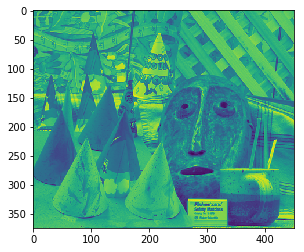

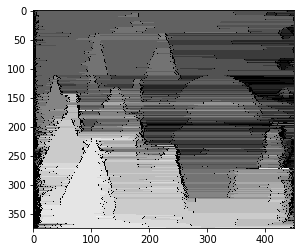

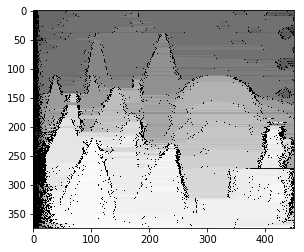

In [0]:
print("GAP PENALTY: {}, EGAP PENALTY: {}, MATCH_SCORE: {}".format(GAP_SCORE, EGAP_SCORE, MATCH_SCORE_TWO_SEQ))

plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()

GAP PENALTY: -16, EGAP PENALTY: -2, MATCH_SCORE: 83


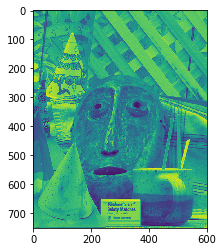

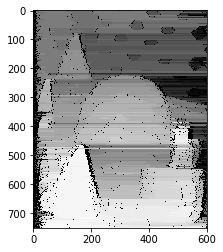

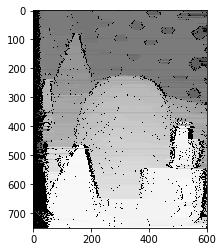

In [18]:
print("GAP PENALTY: {}, EGAP PENALTY: {}, MATCH_SCORE: {}".format(GAP_SCORE, EGAP_SCORE, MATCH_SCORE_TWO_SEQ))

plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()

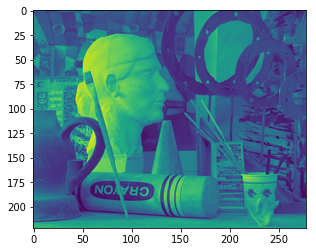

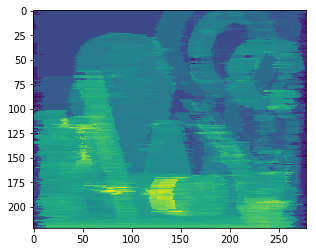

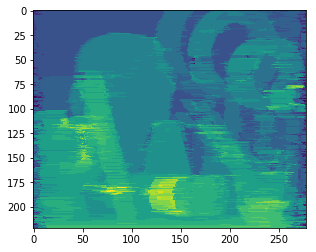

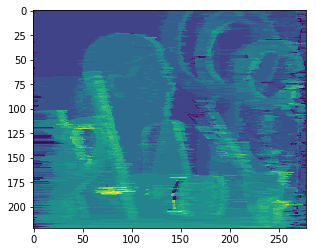

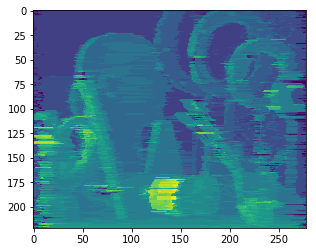

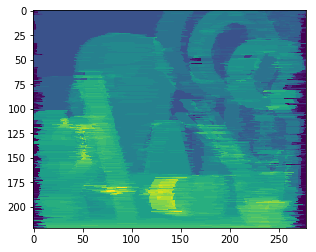

In [0]:
plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap)
plt.show()
plt.imshow(disparityMap2)
plt.show()
plt.imshow(disparityMap3)
plt.show()
plt.imshow(disparityMap4)
plt.show()
plt.imshow(disparityMap5)
plt.show()
 

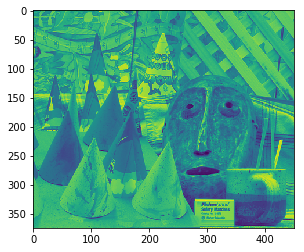

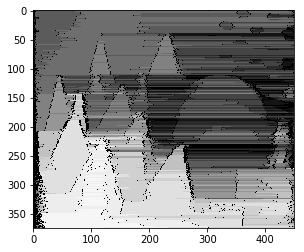

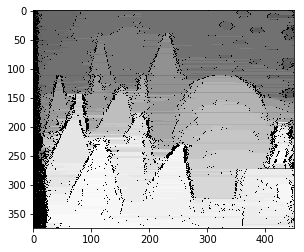

In [0]:
print("GAP SCORE: {}".format(GAP_SCORE)) 
print("MATCH_SCORE_TWO_SEQ: {}".format(MATCH_SCORE_TWO_SEQ))

plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()

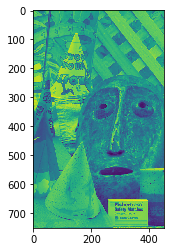

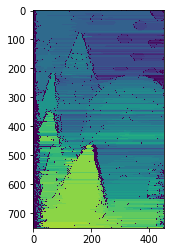

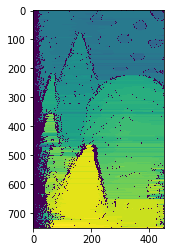

In [0]:
plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap)
plt.show()
plt.imshow(disparityMap2)
plt.show()

GAP SCORE: -8
MATCH_SCORE_TWO_SEQ: 70


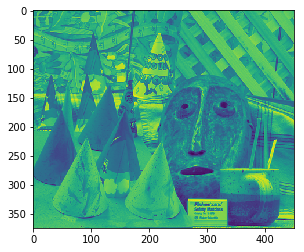

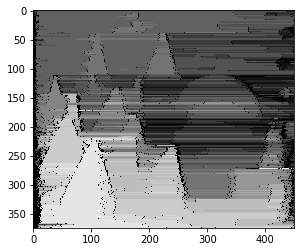

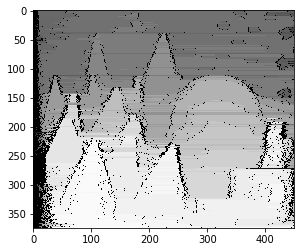

In [0]:
print("GAP SCORE: {}".format(GAP_SCORE)) 
print("MATCH_SCORE_TWO_SEQ: {}".format(MATCH_SCORE_TWO_SEQ))

plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()


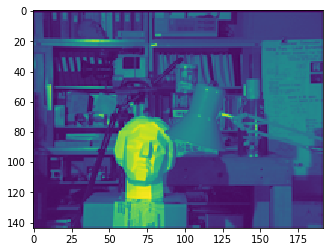

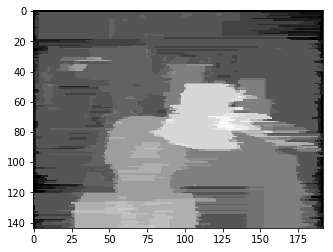

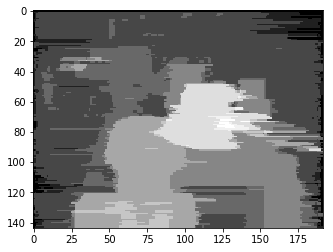

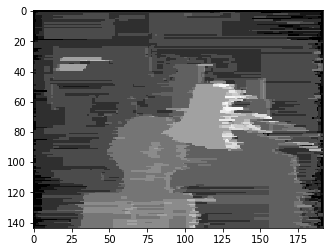

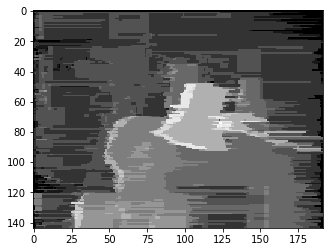

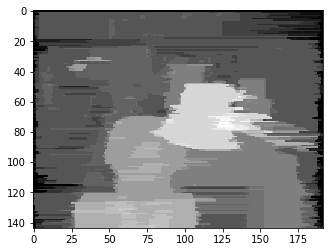

In [0]:
plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap3, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap4, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap5, cmap=matplotlib.cm.Greys_r)
plt.show()

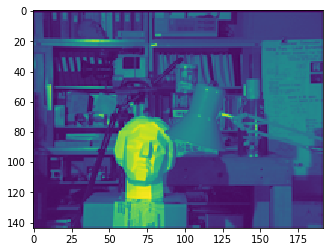

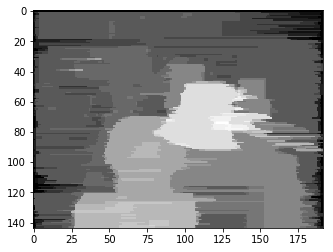

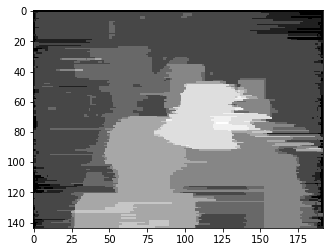

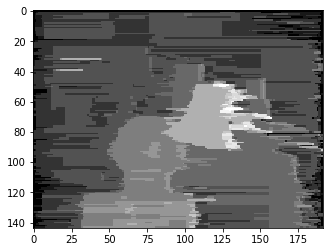

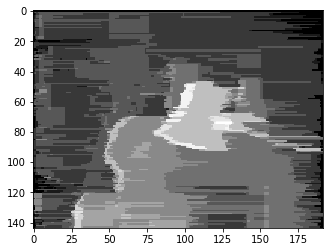

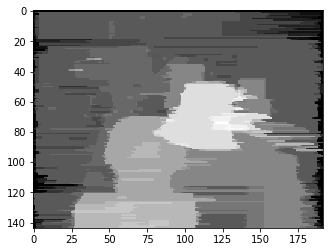

In [0]:
plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap3, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap4, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap5, cmap=matplotlib.cm.Greys_r)
plt.show()

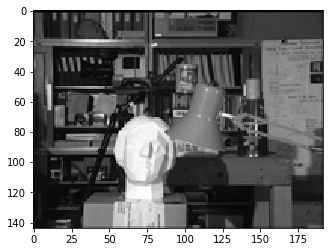

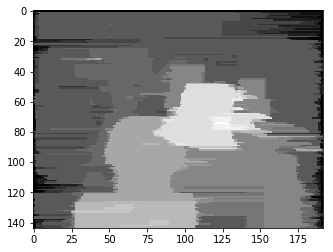

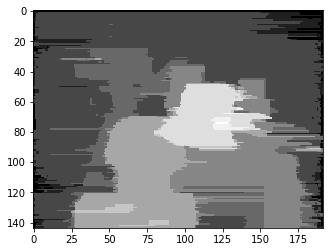

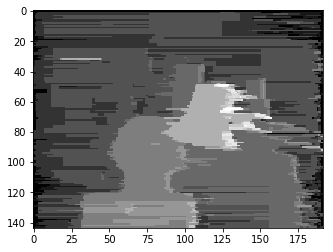

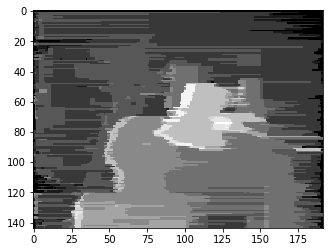

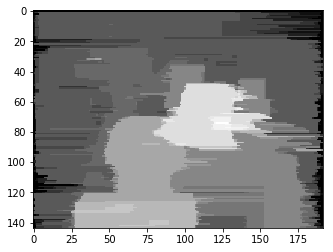

In [0]:
plt.imshow(numpyMiddleImg, cmap=matplotlib.cm.Greys_r)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap3, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap4, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap5, cmap=matplotlib.cm.Greys_r)
plt.show()

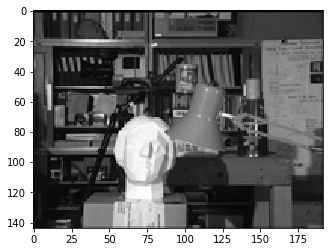

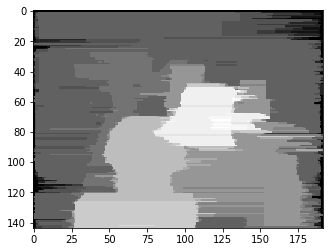

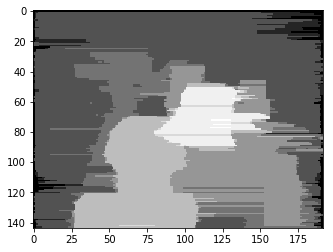

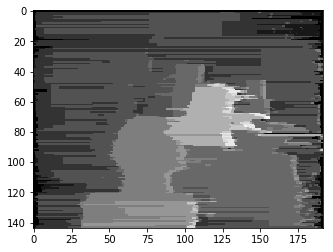

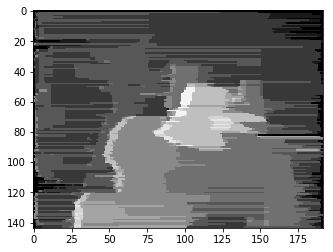

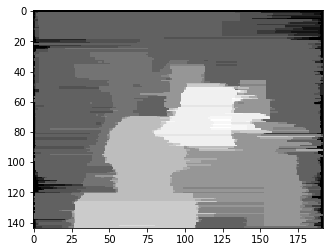

In [0]:
plt.imshow(numpyMiddleImg, cmap=matplotlib.cm.Greys_r)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap3, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap4, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap5, cmap=matplotlib.cm.Greys_r)
plt.show()

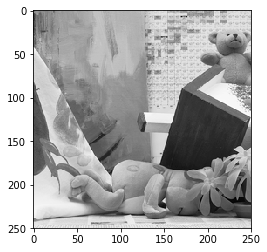

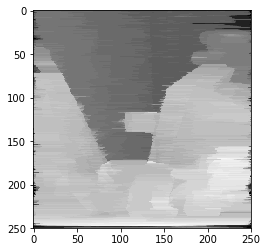

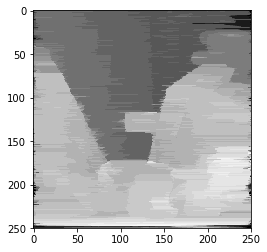

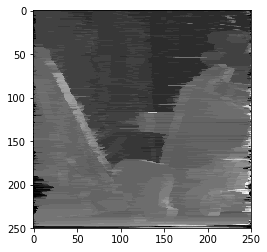

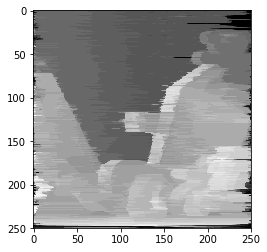

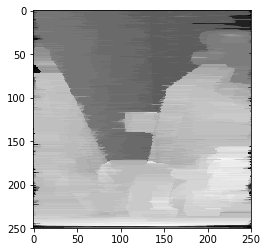

In [0]:
plt.imshow(numpyMiddleImg, cmap=matplotlib.cm.Greys_r)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap3, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap4, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap5, cmap=matplotlib.cm.Greys_r)
plt.show()

In [0]:
plt.imsave("disparityMap_art_1", disparityMap3)
plt.imsave("disparityMap_art_2", disparityMap4)

In [0]:
!nvidia-smi

Wed Jul 24 10:33:52 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    70W / 149W |   3677MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

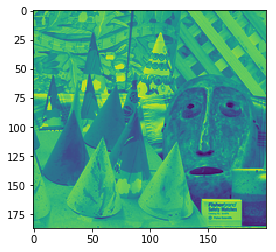

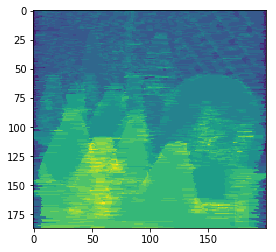

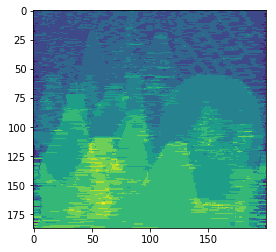

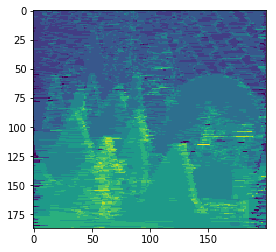

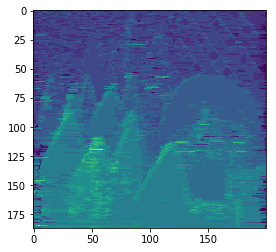

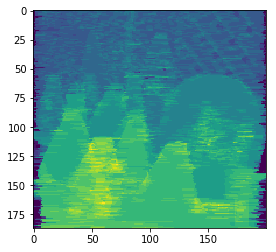

In [0]:
plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap)
plt.show()
plt.imshow(disparityMap2)
plt.show()
plt.imshow(disparityMap3)
plt.show()
plt.imshow(disparityMap4)
plt.show()
plt.imshow(disparityMap5)
plt.show()

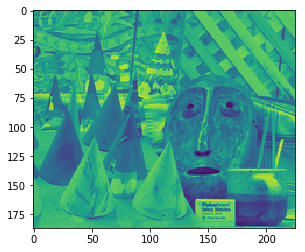

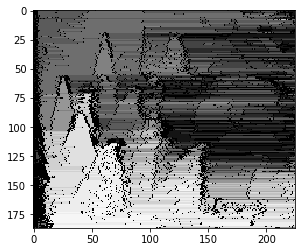

In [0]:
plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()